# Processing Compass Outs

# References
https://yoseflab.github.io/Compass/notebooks/Demo-micropools.html

https://yoseflab.github.io/Compass/notebooks/Demo.html

# Setup

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import scipy
import matplotlib.pyplot as plt
from matplotlib import __version__ as matplotlibversion
if matplotlibversion < "3.4":
    print("Matplotlib versions older than 3.4 may not be able to generate figure 2E, as they do not support alpha arrays")
    
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

In [2]:
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
	"""
		Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
	"""
	#per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
	group_A = consistencies_matrix.loc[:,group_A_cells]
	group_B = consistencies_matrix.loc[:,group_B_cells]
	results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
	for rxn in consistencies_matrix.index:
		A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
		#sometimes there's a solitary value, and we don't want to test then
		if len(np.unique(A)) == 1 and len(np.unique(B)) == 1:
			if np.unique(A) == np.unique(B):
				#we've got no data. set p-value to 1 and skip!
				#(p-value needs to be 1 so multipletests doesn't cry)
				results.loc[rxn, ['wilcox_pval']] = 1
				continue
		stat, pval = mannwhitneyu(A, B, alternative='two-sided')
		c_d = cohens_d(A, B)
		results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
	results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
	return results

def get_reaction_consistencies(compass_reaction_penalties, min_range=1e-3):
    """
        Converts the raw penalties outputs of compass into scores per reactions where higher numbers indicate more activity
    """
    df = -np.log(compass_reaction_penalties + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= min_range]
    df = df - df.min().min()
    return df

def get_metareactions(reactions, height=0.02):
    """
        Returns an array of metareaction labels for each reaction
        Index k in the returned array has the metareaction label for reaction k.
    """
    #pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
    pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
    #Unfortunately due to floating point issues, these matrices are not always perfectly symmetric and the diagonal may be slightly off from 1
    pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
    pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2
    assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

    Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))
    return hcluster.fcluster(Z, height, criterion='distance')

labeled_reactions = {
    "PGM_neg" : "phosphoglycerate mutase (PGAM)",
    "LDH_L_neg" : "lactate dehydrogenase",
    "PDHm_pos" : "pyruvate dehydrogenase (PDH)",
    "TPI_neg" : "triosephosphate isomerase (DHAP forming)",
    "FACOAL1821_neg" : "long-chain fatty-acid-CoA ligase",
    "r1257_pos" : "long-chain fatty-acid-CoA ligase",
    "FACOAL1831_neg" : "long-chain fatty-acid-CoA ligase",
    "CSNATr_neg" : "carnitine O-acetyltransferase",
    "C160CPT1_pos" : "carnitine O-palmitoyltransferase",
    "ACONTm_pos" : "aconitate hydratase",
    "SUCOASm_pos" : "succinate-CoA ligase",
    "AKGDm_pos" : "alpha-ketoglutarate dehydrogenase",
    "SUCD1m_pos" : "succinate dehydrogenase",
    "ICDHyrm_pos" : "isocitrate dehydrogenase",
    "CK_pos" : "creatine\nkinase",
    "PGCD_pos" : "phosphoglycerate dehydrogenase",
    "ARGSS_pos" : "arginosuccinate synthase",
    "r0281_neg" : "putrescine diamine oxidase",
    "SPMDOX_pos" : "spermidine dehydrogenase (spermidine -> GABA)",
    "ARGDCm_pos" : "arginine decarboxylase",
    "AGMTm_pos" : "agmatinase",
    "GHMT2r_pos" : "serine hydroxymethyltransferase",
    "AHC_pos" : "adenosylhomocysteinase",
    "METAT_pos" : "methionine adenosyltransferase",
    "METS_pos" : "methionine\nsynthase",
    "ARGN_pos" : "arginase"
}

amino_acid_metab = ["Alanine and aspartate metabolism",
            "Arginine and Proline Metabolism",
            "beta-Alanine metabolism",
            "Cysteine Metabolism",
            "D-alanine metabolism",
            "Folate metabolism",
            "Glutamate metabolism",
            "Glycine, serine, alanine and threonine metabolism",
            "Histidine metabolism",
            "Lysine metabolism",
            "Methionine and cysteine metabolism",
            "Taurine and hypotaurine metabolism",
            "Tryptophan metabolism",
            "Tyrosine metabolism",
            "Urea cycle",
            "Valine, leucine, and isoleucine metabolism"]

def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-2.2, 2.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate(cellA, xy=(0.75, -0.12), xycoords='axes fraction', fontsize=10)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08),
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate(cellB, xy=(0.25, -0.12), xycoords='axes fraction', fontsize=10)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset,
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

# Match cell types to micropools

In [3]:
cell_md = pd.read_csv('/nfs/team205/heart/compass/fetal_allcells/cell_metadata.csv', index_col = 0)
micropools = pd.read_csv('/nfs/team205/heart/compass/fetal_allcells/out/micropools.tsv', index_col = 0, sep ='\t')

In [4]:
df=pd.merge(cell_md, micropools, left_index=True, right_index=True).sort_values(by=['microcluster'])
df.head(3)

,coarse_grain,fine_grain,microcluster
BHF_F_Hea11933667_BHF_F_Hea11596620_TCTAATCTCCGTGACA-1,Cardiomyocytes,VentricularCardiomyocytesPRRX1pos,0
BHF_F_Hea11933665_BHF_F_Hea11596618_GATTAGCTCATGCTTT-1,Cardiomyocytes,VentricularCardiomyocytesCompact,0
BHF_F_Hea11933664_BHF_F_Hea11596617_ACCACATAGGATTGCT-1,Cardiomyocytes,VentricularCardiomyocytesCompact,0


In [5]:
df['fine_grain'].unique().tolist()

['VentricularCardiomyocytesPRRX1pos',
 'VentricularCardiomyocytesCompact',
 'VentricularCardiomyocytesTrabeculated',
 'VentricularConductionSystemProximal',
 'VentricularCardiomyocytesCycling',
 'VentricularConductionSystemDistal',
 'Cardiofibromyocytes',
 'AtrialCardiomyocytesLeft',
 'AtrialCardiomyocytesRight',
 'GreatVesselAdventitialFibroblasts',
 'CoronaryVesselAdventitialFibroblasts',
 'MyocardialInterstitialFibroblasts',
 'GreatVesselProgenitors',
 'Myofibroblasts',
 'GreatVesselSmoothMuscleCells',
 'ValveInterstitialCells',
 'GreatVesselEndothelialCells',
 'CoronaryPericytes',
 'CoronarySmoothMuscleCells',
 'ChromaffinCells',
 'FibroblasticEpicardialCells',
 'SatelliteGlialCells',
 'EndocardialCells',
 'MesothelialEpicardialCells',
 'TCells',
 'CoronaryEndothelialCellsArterial',
 'Platelets',
 'CoronaryEndothelialCellsCapillary',
 'LymphaticEndothelialCells',
 'ProBCells',
 'SatelliteGlialCellProgenitors',
 'InnateLymphoidCells',
 'MacrophagesLYVE1pos',
 'AtrioventricularNodeCa

In [6]:
# for each cluster find out which is the commonest cell type and what its % is
clusters=[]
modes=[]
pct=[]

for i in df['microcluster'].unique().tolist():
    clusters.append('cluster_'+str(i))
    mode=df['fine_grain'][df['microcluster']==i].mode()[0]
    modes.append(mode)
    pct.append(len(df['fine_grain'][(df['microcluster']==i)&(df['fine_grain']==mode)])/(len(df['fine_grain'][(df['microcluster']==i)&(df['fine_grain']==mode)])+len(df['fine_grain'][(df['microcluster']==i)&(df['fine_grain']!=mode)])))

In [7]:
micropool_md = {'microclusters':clusters,
      'modal cell state': modes,
      'percentage': pct,
     }
micropool_md=pd.DataFrame.from_dict(micropool_md)
micropool_md=micropool_md.set_index('microclusters')

<AxesSubplot:>

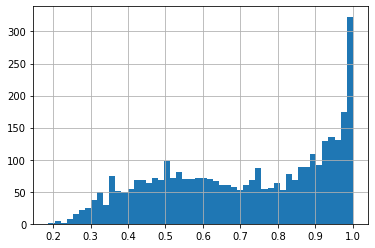

In [8]:
micropool_md['percentage'].hist(bins = 50)

In [9]:
micropool_md[(micropool_md['percentage']>0.8)]

,modal cell state,percentage
microclusters,,
cluster_19,VentricularCardiomyocytesPRRX1pos,0.904762
cluster_26,VentricularCardiomyocytesCycling,0.939394
cluster_62,VentricularCardiomyocytesPRRX1pos,0.947368
cluster_88,VentricularCardiomyocytesPRRX1pos,0.900000
cluster_108,VentricularCardiomyocytesPRRX1pos,0.828571
...,...,...
cluster_3515,SatelliteGlialCells,0.950000
cluster_3516,SatelliteGlialCells,0.986842
cluster_3517,SatelliteGlialCells,0.888889


In [10]:
# save this metadata output
micropool_md.to_csv('/nfs/team205/heart/compass/fetal_allcells/cluster_metadata.csv')

In [11]:
cell_states = micropool_md['modal cell state'].unique()

for cell_state in cell_states:
    print(cell_state+'_'+str(len(micropool_md[micropool_md['modal cell state']==cell_state])))

VentricularCardiomyocytesPRRX1pos_219
VentricularCardiomyocytesTrabeculated_138
VentricularCardiomyocytesCompact_308
VentricularCardiomyocytesCycling_223
Cardiofibromyocytes_112
VentricularConductionSystemProximal_5
MyocardialInterstitialFibroblasts_314
GreatVesselAdventitialFibroblasts_371
Myofibroblasts_28
CoronaryPericytes_52
CoronaryVesselAdventitialFibroblasts_34
ValveInterstitialCells_157
GreatVesselProgenitors_273
TCells_12
CoronarySmoothMuscleCells_29
GreatVesselSmoothMuscleCells_142
FibroblasticEpicardialCells_7
MesothelialEpicardialCells_34
Platelets_18
AtrialCardiomyocytesLeft_131
AtrialCardiomyocytesRight_107
SinoatrialNodeCardiomyocytes_16
AtrioventricularNodeCardiomyocytes_7
VentricularConductionSystemDistal_21
MacrophagesCX3CR1pos_13
MacrophagesLYVE1pos_177
Monocytes_39
DendriticCells_7
CoronaryEndothelialCellsVenous_3
EndocardialCells_163
GreatVesselEndothelialCells_20
ValvalEndothelialCells_7
CoronaryEndothelialCellsArterial_7
NaturalKillerCells_26
InnateLymphoidCells_

# Generate reaction consistencies

The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that are higher the more active the reaction is predicted to be. This also drops reactions that are close to constant and therefore not informative for the comparison.

In [12]:
reaction_penalties = pd.read_csv("/nfs/team205/heart/compass/fetal_allcells/out/reactions.tsv", sep="\t", index_col = 0)
reaction_penalties

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_3512,cluster_3513,cluster_3514,cluster_3515,cluster_3516,cluster_3517,cluster_3518,cluster_3519,cluster_3520,cluster_3521
10FTHF5GLUtl_pos,4342.549150,4342.882816,4369.440333,4413.170006,4342.755873,4316.897081,4418.178181,4424.180323,4409.634227,4295.164525,...,4266.364588,4354.780920,4145.004679,4277.626591,4255.092224,4337.128172,4186.319832,4216.910628,4312.669262,4274.668556
10FTHF5GLUtm_pos,5695.479636,5750.571012,5770.843958,5771.650229,5698.937649,5741.625531,5830.489507,5767.791979,5793.275191,5624.893614,...,5822.722550,5996.943699,5799.750760,5870.363346,5965.431475,6230.821376,5800.840841,5823.510747,6006.643743,5816.580304
10FTHF6GLUtl_pos,5410.476724,5426.343324,5428.862882,5528.535689,5359.286953,5368.186555,5547.456608,5537.794485,5515.184897,5298.741778,...,5313.111329,5454.888949,5118.204144,5331.895970,5295.216077,5427.667354,5184.931239,5234.542838,5387.587563,5326.288881
10FTHF6GLUtm_pos,6135.361570,6204.711445,6227.352594,6237.821107,6129.247390,6177.726659,6299.983716,6227.889360,6250.092361,6055.008758,...,6206.559117,6418.352802,6136.536710,6250.802445,6376.815774,6726.813576,6166.360396,6175.510572,6409.923826,6212.705460
10FTHF7GLUtl_pos,5936.600372,5955.704464,5958.159848,6080.719120,5872.390263,5898.132713,6101.092378,6091.156634,6061.510256,5803.131433,...,5892.260388,6056.211518,5666.038669,5874.497421,5892.548074,6127.392396,5760.699666,5769.966763,5957.396187,5862.420866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_pre_prot(r)_pos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sink_tetdec2coa(c)_neg,20022.969692,20282.061548,20179.432839,20564.803868,20127.676842,20335.133868,20651.916373,20346.351141,20560.071260,19973.177279,...,20475.730184,20904.007410,20411.315895,20534.102296,20902.851830,21381.281848,20465.868529,20550.245174,20983.020351,20698.129220
sink_tetdec2coa(c)_pos,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sink_tetdece1coa(c)_neg,20022.969692,20282.061548,20179.432839,20564.803868,20127.676842,20335.133868,20651.916373,20346.351141,20560.071260,19973.177279,...,20475.730184,20904.007410,20411.315895,20534.102296,20902.851830,21381.281848,20465.868529,20550.245174,20983.020351,20698.129220


In [13]:
# this is a reference file - not specific to each run of Compass
reaction_metadata = pd.read_csv("/home/jovyan/COMPASSResources/reaction_metadata.csv", index_col = 0)
reaction_metadata

,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
reaction_no_direction,,,,,,
10FTHF5GLUtl,"5-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](5) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF5GLUtm,"5-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](5) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF6GLUtl,"6-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](6) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
10FTHF6GLUtm,"6-glutamyl-10FTHF transport, mitochondrial",1.00 * 10-formyltetrahydrofolate-[Glu](6) [m] ...,NaN,"Transport, mitochondrial",NaN,2.0
10FTHF7GLUtl,"7-glutamyl-10FTHF transport, lysosomal",1.00 * 10-formyltetrahydrofolate-[Glu](7) [c] ...,NaN,"Transport, lysosomal",NaN,2.0
...,...,...,...,...,...,...
MAL_Lte,Transport of L-malate,1.00 * (S)-malate(2-) [e] --> 1.00 * (S)-malat...,NaN,"Transport, extracellular",NaN,NaN
OROTGLUt,OROTGLUt,1.00 * L-glutamate(1-) [c] + 1.00 * Orotate [e...,SLC22A7,"Transport, extracellular",NaN,NaN
PNTOte,Transport of (R)-Pantothenate,1.00 * (R)-Pantothenate [e] --> 1.00 * (R)-Pan...,NaN,"Transport, extracellular",NaN,NaN


In [14]:
# example for one reaction
reaction_metadata.loc['r0281']['formula']

'1.00 * Water [e] + 1.00 * O2 [e] + 1.00 * Putrescine [e] --> 1.00 * Ammonium [e] + 1.00 * Hydrogen peroxide [e] + 1.00 * 4-Aminobutanal [e]\nAOC1'

In [15]:
reaction_consistencies = get_reaction_consistencies(reaction_penalties)
reaction_consistencies['r_id'] = ""
for r in reaction_consistencies.index:
    if r in reaction_consistencies.index:
        reaction_consistencies.loc[r, 'r_id'] = r[:-4]
    else:
        print("Should not occur")
reaction_consistencies

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,...,cluster_3513,cluster_3514,cluster_3515,cluster_3516,cluster_3517,cluster_3518,cluster_3519,cluster_3520,cluster_3521,r_id
10FTHF5GLUtl_pos,3.588232,3.588155,3.582060,3.572104,3.588185,3.594155,3.570970,3.569613,3.572905,3.599201,...,3.585420,3.634779,3.603292,3.608573,3.589481,3.624863,3.617584,3.595135,3.603984,10FTHF5GLUtl
10FTHF5GLUtm_pos,3.317076,3.307451,3.303932,3.303793,3.316469,3.309007,3.293652,3.304461,3.300054,3.329544,...,3.265507,3.298937,3.286837,3.270775,3.227255,3.298749,3.294849,3.263891,3.296040,10FTHF5GLUtm
10FTHF6GLUtl_pos,3.368402,3.365474,3.365010,3.346820,3.377906,3.376248,3.343404,3.345147,3.349238,3.389266,...,3.360228,3.423925,3.383030,3.389931,3.365230,3.410975,3.401453,3.372641,3.384082,10FTHF6GLUtl
10FTHF6GLUtm_pos,3.242692,3.231454,3.227812,3.226133,3.243689,3.235812,3.216218,3.227726,3.224168,3.255873,...,3.197607,3.242501,3.224054,3.204098,3.150674,3.237653,3.236171,3.198921,3.230167,10FTHF6GLUtm
10FTHF7GLUtl_pos,3.275619,3.272407,3.271994,3.251637,3.286492,3.282119,3.248292,3.249922,3.254800,3.298354,...,3.255674,3.322257,3.286133,3.283066,3.243992,3.305691,3.304084,3.272123,3.288191,10FTHF7GLUtl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sink_decdicoa(c)_neg,2.059994,2.047138,2.052211,2.033294,2.054778,2.044525,2.029067,2.043973,2.033524,2.062484,...,2.016935,2.040786,2.034788,2.016991,1.994361,2.038117,2.034002,2.013163,2.026832,sink_decdicoa(c)
sink_octdececoa(c)_neg,1.723909,1.712848,1.716439,1.697758,1.723315,1.708376,1.685712,1.706400,1.695777,1.731171,...,1.673264,1.683102,1.693199,1.665401,1.631181,1.695746,1.688556,1.666066,1.682331,sink_octdececoa(c)
sink_pre_prot(r)_neg,7.525455,7.508837,7.518633,7.508571,7.528418,7.517965,7.505945,7.512097,7.506963,7.528321,...,7.517011,7.540267,7.533567,7.519704,7.494946,7.533232,7.529875,7.511064,7.518592,sink_pre_prot(r)
sink_tetdec2coa(c)_neg,2.059994,2.047138,2.052211,2.033294,2.054778,2.044525,2.029067,2.043973,2.033524,2.062484,...,2.016935,2.040786,2.034788,2.016991,1.994361,2.038117,2.034002,2.013163,2.026832,sink_tetdec2coa(c)


# Compare cells of interest
We use the unpaired Wilcoxon rank-sum test (equivlanet to the Mann–Whitney U test) to analyze which reactions are predicted to be more active

In [16]:
micropool_md.head(3)

,modal cell state,percentage
microclusters,,
cluster_0,VentricularCardiomyocytesPRRX1pos,0.339623
cluster_1,VentricularCardiomyocytesTrabeculated,0.415385
cluster_2,VentricularCardiomyocytesCompact,0.641026


In [17]:
cellA='MyocardialInterstitialFibroblasts'
cellB='GreatVesselAdventitialFibroblasts'
threshold = 0.9

In [18]:
#get clusters which refer to cell types of interest
cellA_clusters = micropool_md.index[(micropool_md['modal cell state'] == cellA)&(micropool_md['percentage']>threshold)]
cellB_clusters = micropool_md.index[(micropool_md['modal cell state'] != cellA)&(micropool_md['percentage']>threshold)]

In [19]:
wilcox_results = wilcoxon_test(reaction_consistencies, cellA_clusters, cellB_clusters)
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [20]:
wilcox_results

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
10FTHF5GLUtl_pos,29864.0,0.002504,-0.406185,0.004835,10FTHF5GLUtl
10FTHF5GLUtm_pos,28391.0,0.000301,-0.327817,0.000896,10FTHF5GLUtm
10FTHF6GLUtl_pos,29767.0,0.002200,-0.412639,0.004345,10FTHF6GLUtl
10FTHF6GLUtm_pos,29330.0,0.001206,-0.312868,0.002550,10FTHF6GLUtm
10FTHF7GLUtl_pos,29658.0,0.001899,-0.424164,0.003804,10FTHF7GLUtl
...,...,...,...,...,...
sink_decdicoa(c)_neg,30286.0,0.004325,-0.443047,0.007835,sink_decdicoa(c)
sink_octdececoa(c)_neg,28081.0,0.000185,-0.496171,0.000604,sink_octdececoa(c)
sink_pre_prot(r)_neg,34030.0,0.177042,-0.225499,0.208196,sink_pre_prot(r)
sink_tetdec2coa(c)_neg,30286.0,0.004325,-0.443047,0.007835,sink_tetdec2coa(c)


Next we join the metadata to the reactions in a new dataframe W, so that we can filter out non-core reactions. More specifically, we remove reactions with confidence other than 0 or 4 (4 = most confident; 0 = unassigned confidence). In the original Compass paper they filtered out reactions in the citric acid cycle subsystem which are outside of the mitochondria.

In [21]:
W = wilcox_results.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

In [22]:
W[W['confidence']==4]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id,reaction_name,formula,associated_genes,subsystem,EC_number,confidence
2HBO_neg,28125.0,0.000198,-0.513826,0.000637,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,Propanoate metabolism,1.1.1.27,4.0
2HBO_pos,36951.0,0.859589,-0.218820,0.866646,2HBO,2-Hydroxybutyrate:NAD+ oxidoreductase,1.00 * 2-Hydroxybutyrate [c] + 1.00 * Nicotina...,LDHA; LDHAL6B; LDHB; LDHC; UEVLD,Propanoate metabolism,1.1.1.27,4.0
34DHOXPEGOX_pos,34849.0,0.307243,-0.159996,0.335376,34DHOXPEGOX,"3,4-Dihydroxyphenylethyleneglycol:NAD+ oxidore...",1.00 * proton [c] + 1.00 * Nicotinamide adenin...,ADH1; ADH4; ADH5; ADH6A; ADH7; ADHFE1,Tyrosine metabolism,1.1.1.1,4.0
34DHPLACOX_NADP__neg,40739.0,0.178982,0.061686,0.210402,34DHPLACOX_NADP_,"3,4-Dihydroxyphenylacetaldehyde:NADP+ oxidored...",1.00 * Water [c] + 1.00 * Nicotinamide adenine...,ALDH3A1; ALDH3B1; ALDH3B3,Tyrosine metabolism,1.2.1.5,4.0
34DHPLACOX_pos,40739.0,0.178982,0.061686,0.210402,34DHPLACOX,"3,4-Dihydroxyphenylacetaldehyde:NAD+ oxidoredu...",1.00 * Water [c] + 1.00 * Nicotinamide adenine...,ALDH1A3; ALDH3A1; ALDH3B1; ALDH3B3,Tyrosine metabolism,1.2.1.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...
XAO2x_pos,28097.0,0.000190,-0.457206,0.000616,XAO2x,xanthine oxidase,1.00 * O2 [x] + 1.00 * Water [x] + 1.00 * Hypo...,XDH,Purine catabolism,1.1.1.204,4.0
XAOx_pos,27936.0,0.000146,-0.463779,0.000498,XAOx,"xanthine oxidase,peroxisomal",1.00 * O2 [x] + 1.00 * Water [x] + 1.00 * Xant...,XDH,Purine catabolism,1.1.1.204,4.0
XYLK_pos,28725.0,0.000501,-0.460425,0.001286,XYLK,xylulokinase,1.00 * ATP [c] + 1.00 * D-xylulose [c] --> 1.0...,XYLB,Pentose phosphate pathway,2.7.1.17,4.0
XYLUR_neg,38313.0,0.711638,-0.003279,0.726141,XYLUR,xylulose reductase,1.00 * proton [c] + 1.00 * Nicotinamide adenin...,DCXR,Pentose phosphate pathway,1.1.1.10,4.0


# Plotting results

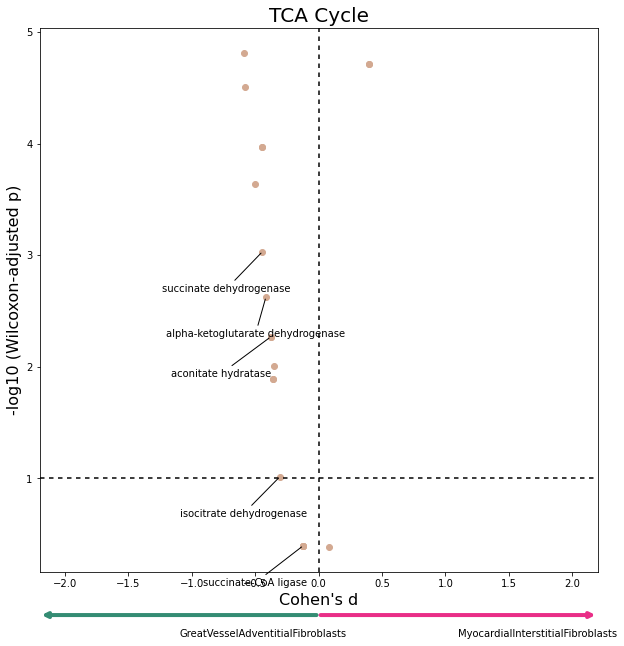

In [23]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

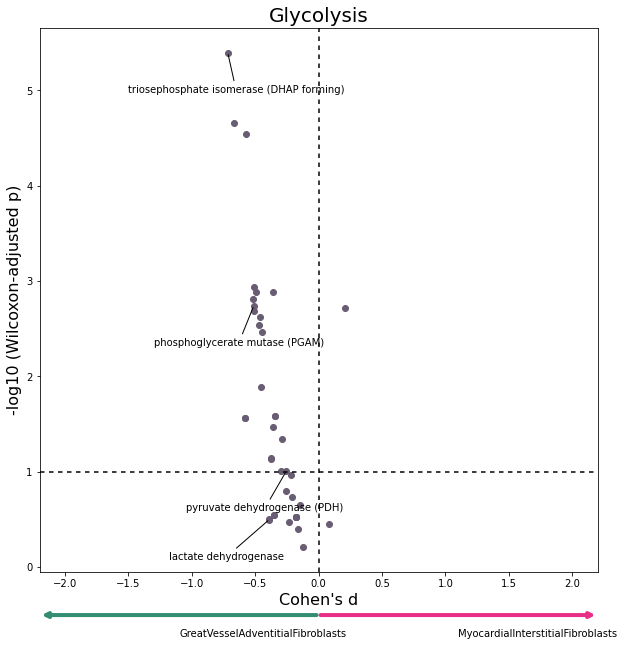

In [24]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

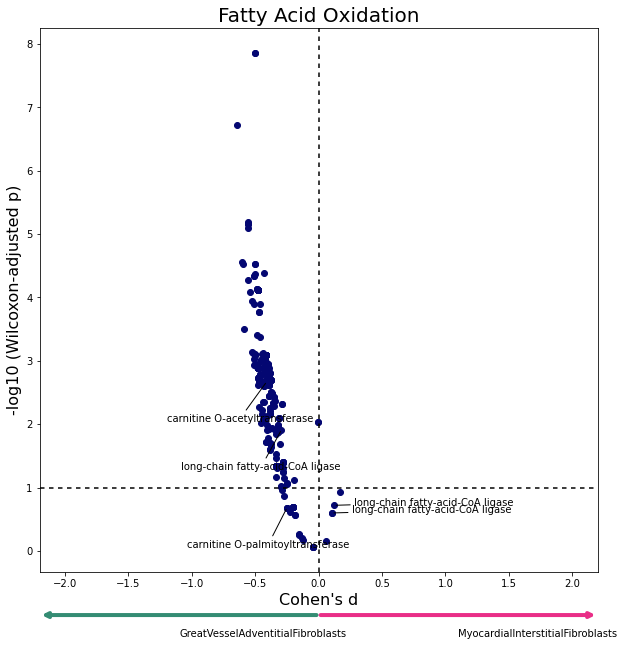

In [25]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

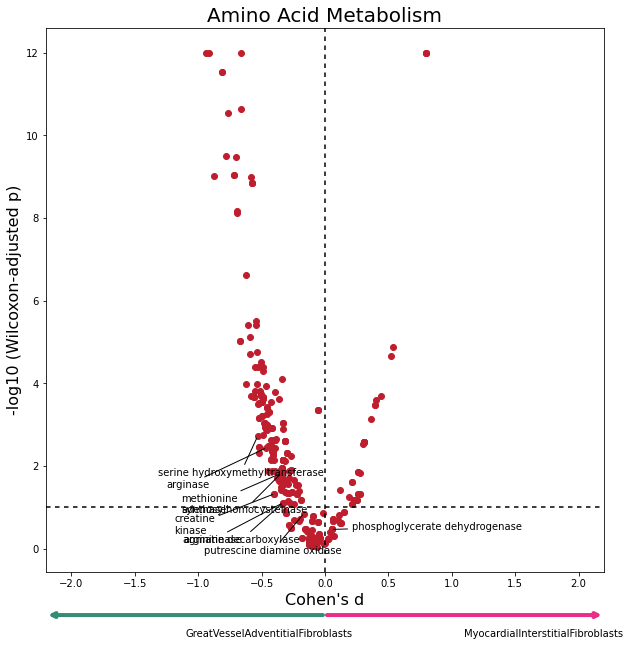

In [26]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

In [27]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 0, "Cohen's d")

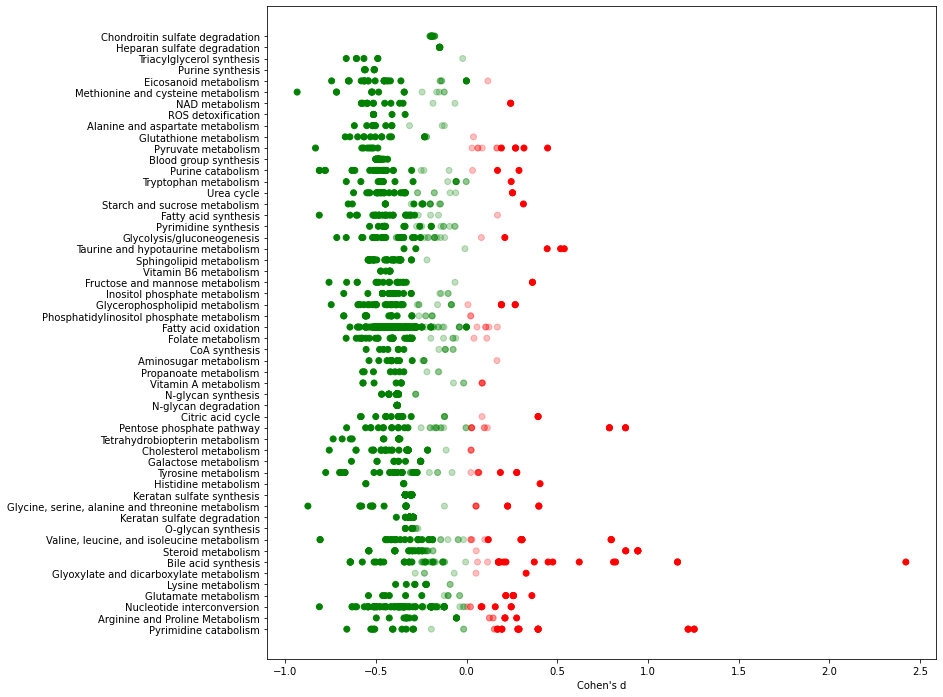

In [28]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.2].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'g')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")

# Meta reactions

In [29]:
reaction_penalties[reaction_penalties <= 1e-4] = 0
reaction_penalties = reaction_penalties[np.all(reaction_penalties != 0, axis=1)]

reaction_penalties = reaction_penalties[reaction_penalties.max(axis=1) - reaction_penalties.min(axis=1) != 0]

In [30]:
meta_rxns_map = get_metareactions(reaction_penalties)
meta_rxns = reaction_penalties.join(pd.DataFrame(meta_rxns_map, columns=["meta_rxn_id"], index = reaction_penalties.index)).groupby("meta_rxn_id").mean()

In [31]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [32]:
wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, cellA_clusters, cellB_clusters)

In [33]:
wilcox_meta_rxn_expanded = pd.DataFrame(index=reaction_penalties.index, columns=wilcox_meta_rxn_results.columns)
for i in range(len(wilcox_meta_rxn_expanded.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_meta_rxn_expanded.loc[wilcox_meta_rxn_expanded.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]
wilcox_meta_rxn_expanded = wilcox_meta_rxn_expanded.dropna().astype('float64')

In [34]:
wilcox_meta_rxn_expanded['metadata_r_id'] = ""
for r in wilcox_meta_rxn_expanded.index:
    if r in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_meta_rxn_expanded.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

In [35]:
W = wilcox_meta_rxn_expanded.merge(reaction_metadata, how='left',
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

In [36]:
W['subsystem'].unique().tolist()

['Propanoate metabolism',
 'Tyrosine metabolism',
 'Sphingolipid metabolism',
 'Tryptophan metabolism',
 'Taurine and hypotaurine metabolism',
 'Cytochrome metabolism',
 'Steroid metabolism',
 'Glycine, serine, alanine and threonine metabolism',
 'Lysine metabolism',
 'Glutamate metabolism',
 'beta-Alanine metabolism',
 'Valine, leucine, and isoleucine metabolism',
 'Cholesterol metabolism',
 'Fatty acid oxidation',
 'Aminosugar metabolism',
 'Phosphatidylinositol phosphate metabolism',
 'Glycerophospholipid metabolism',
 'Other',
 'Butanoate metabolism',
 'Pyruvate metabolism',
 'Citric acid cycle',
 'Bile acid synthesis',
 'Glycolysis/gluconeogenesis',
 'Purine catabolism',
 'Nucleotide interconversion',
 'Arginine and Proline Metabolism',
 'Nucleotide salvage pathway',
 'Purine synthesis',
 'Keratan sulfate synthesis',
 'Triacylglycerol synthesis',
 'Alanine and aspartate metabolism',
 'Methionine and cysteine metabolism',
 'N-glycan degradation',
 'Miscellaneous',
 'Eicosanoid meta

# Plotting meta reaction results

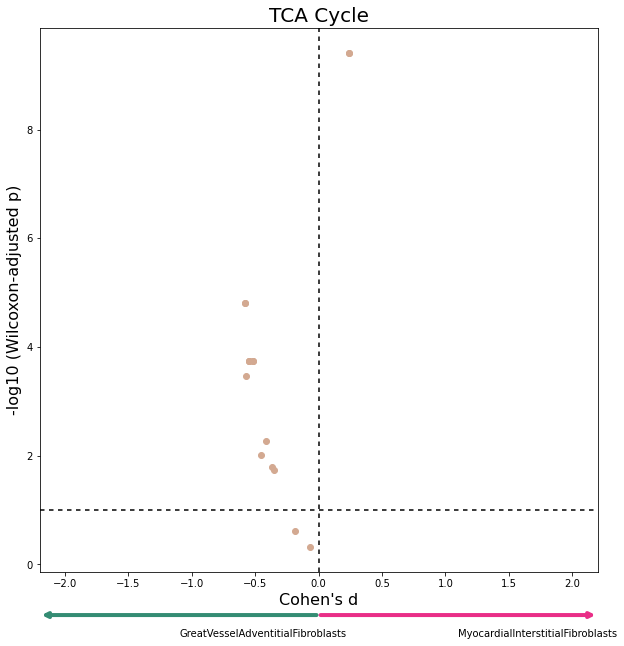

In [37]:
data = W[W['subsystem'] == "NAD metabolism"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

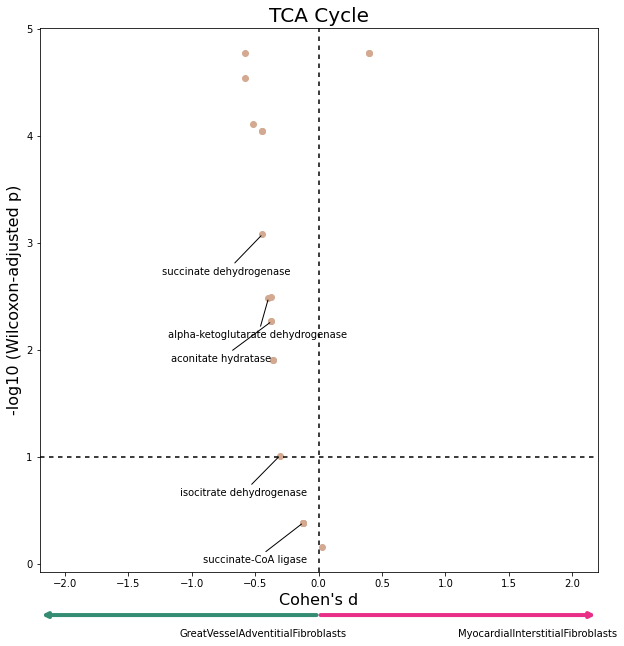

In [38]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

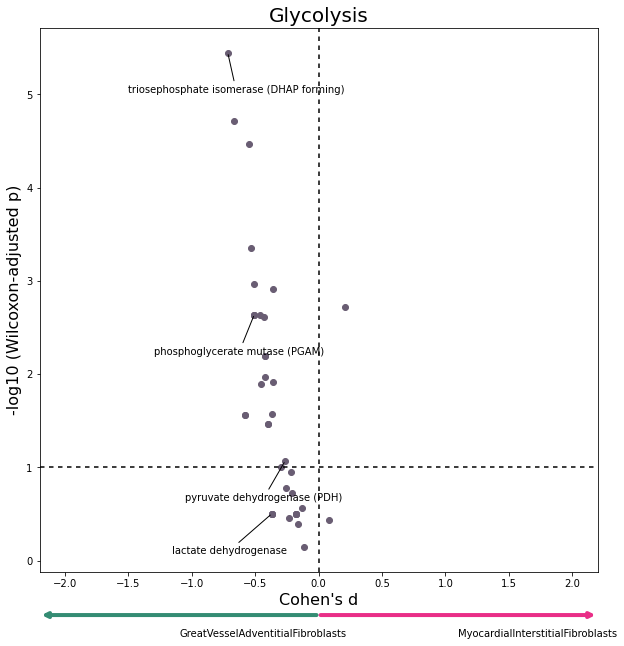

In [39]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

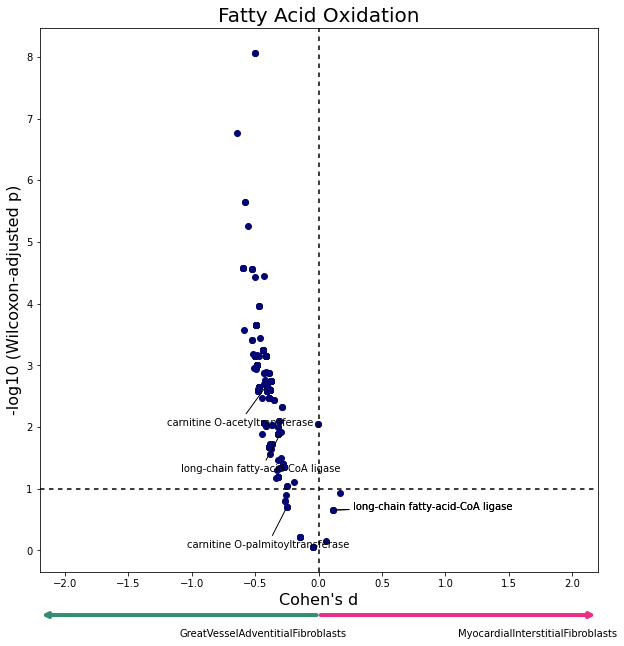

In [40]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

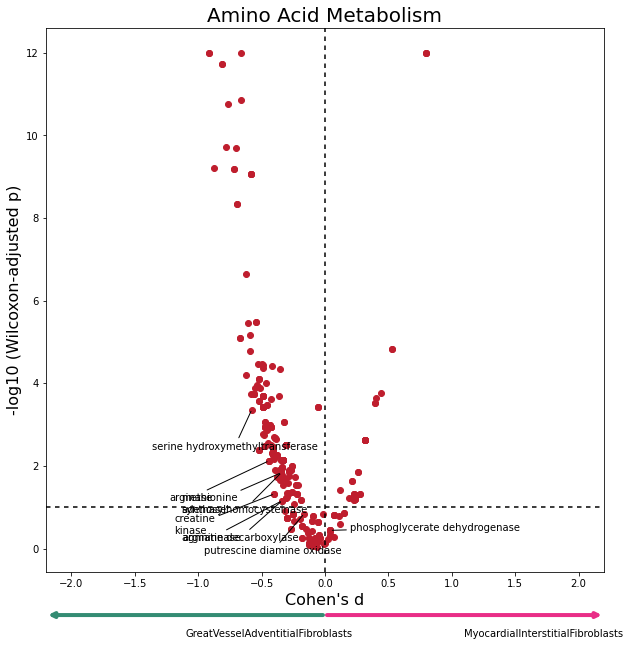

In [41]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

In [42]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 0, "Cohen's d")

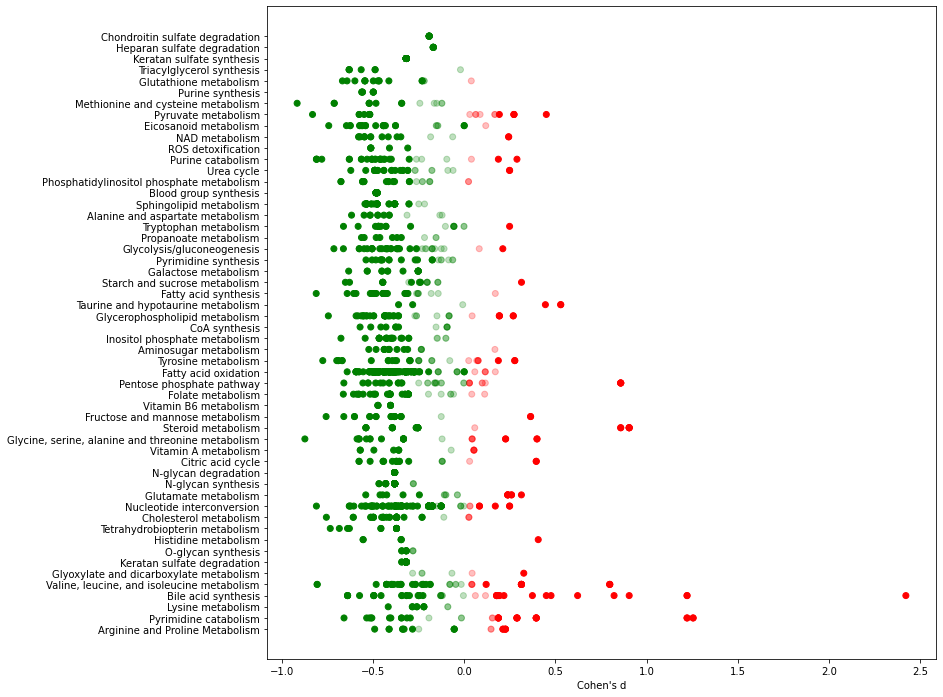

In [43]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.05].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'g')
alpha = data['adjusted_pval'].map(lambda x: 1.0 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")